<a href="https://colab.research.google.com/github/btran30/cs584/blob/brenda/Densenet201_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet 201 Analysis

## Library Import

In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Activation
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.3.0


## Load Data from Keras

In [2]:
def read_data(cifar_dataset):

    if cifar_dataset == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data()
        # One-hot encoding for 100 classes.
        y_train = to_categorical(y_train, 100)
        y_test = to_categorical(y_test, 100)
    else :
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        y_train = to_categorical(y_train, 10)
        y_test = to_categorical(y_test, 10)

    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
    return (x_train, y_train), (x_test, y_test) 

## DenseNet 201 Model

We utilize ImageDataGenerator to augment our input data.  This should help us avoid overfitting.

In [7]:
def run_model(cifar_dataset, x_train, y_train, x_test, y_test):
    
    input_shape=(32,32,3)
    model_d=DenseNet201(weights='imagenet',include_top=False, input_shape=input_shape) 

    x=model_d.output

    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    x= GlobalAveragePooling2D()(x)

    preds=Dense(cifar_dataset ,activation='softmax')(x) #FC-layer

    model=Model(inputs=model_d.input, outputs=preds)

    #model.summary()
    #tf.keras.utils.plot_model( model , show_shapes=True )

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

    batch_size = 128
    epochs = 20

    anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

    datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

    datagen.fit(x_train)
    # Fits-the-model
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                   steps_per_epoch=x_train.shape[0] // batch_size,
                   epochs=epochs,
                   verbose=1,
                   callbacks=[anne],
                   validation_data=(x_test, y_test))
    return history, model

In [3]:
def summarize_diagnostics(history):
    plt.subplots_adjust(hspace=0.7)
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    #filename = "DenseNet201_Pretrained"
    #plt.savefig(filename + '_plot.png')
    
    return history


In [4]:
def final_prediction(model, x_test, y_test):
    ypred = model.predict(x_test)

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1
    
    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')

### Run model

Train: X=(50000, 32, 32, 3), y=(50000, 100)
Test: X=(10000, 32, 32, 3), y=(10000, 100)
74842112/74836368 [==============================] - 1s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
390/390 [==============================] - 50s 128ms/step - loss: 3.4554 - accuracy: 0.2268 - top_k_categorical_accuracy: 0.4449 - val_loss: 2.7163 - val_accuracy: 0.3471 - val_top_k_categorical_accuracy: 0.6394
Epoch 2/20
390/390 [==============================] - 44s 113ms/step - loss: 2.2041 - accuracy: 0.4385 - top_k_categorical_accuracy: 0.7357 - val_loss: 2.3137 - val_accuracy: 0.4269 - val_top_k_categorical_accuracy: 0.7065
Epoch 3/20
390/390 [==============================] - 45s 114ms/step - loss: 1.7833 - accuracy: 0.5272 - top_k_categorical_accuracy: 0.8138 - val_loss: 1.8411 - val_accuracy: 0.5093 - val_top_k_categorical_accuracy: 0.7995
Epoch 4/20
390/390 [==============================] - 44s 113ms/step - loss: 1.5339 - accuracy: 0.5807 

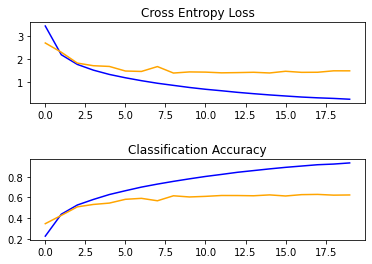

In [8]:
cifar_dataset = 100
(x_train, y_train), (x_test, y_test) = read_data(cifar_dataset)
history, model = run_model(cifar_dataset, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(history)
print('\n')
final_prediction(model, x_test, y_test)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
